In [1]:
from glob import glob
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import json

sns.set(context="paper", style="whitegrid", font_scale=1.5)
%matplotlib inline

In [2]:
exp_name = "200831_cifar10"

In [3]:
def plot_grid(runs, y, yerr=None, ylabel="performance", ylim=None):
    scales = sorted(runs.weight_scale.unique())
    temps = sorted(runs.temperature.unique())
    fig, axes = plt.subplots(len(scales), len(temps), sharex=True, sharey=True, figsize=(10,10))

    for scale, axs in zip(scales, axes):
        for temp, ax in zip(temps, axs):
            df = runs.sort_values(["weight_prior", "weight_scale"]).query(f"weight_scale == {scale} & temperature == {temp}")
            df.plot(x="weight_prior", y=y, yerr=yerr, kind="bar", legend=False, ax=ax)
            ax.set_title(f"scale={scale} and T={temp}")
            ax.set_ylabel(ylabel)
            if ylim is not None:
                ax.set_ylim(ylim)

    fig.tight_layout()
    return fig

In [4]:
runs = []
for config_file in glob(f"../results/{exp_name}/*/eval/*/config.json"):
    with open(config_file) as infile:
        config = pd.Series(json.load(infile))
    with open(config_file[:-11] + "run.json") as infile:
        result = pd.Series(json.load(infile)["result"], dtype=np.float32)
    run_data = pd.concat([config, result])
    runs.append(run_data)
runs_all = pd.concat(runs, axis=1).T

In [7]:
runs_all["error_mean"] = 1. - runs_all["acc_mean"]

In [8]:
runs_all.head()

,accuracy_eval,batch_size,batchnorm,bias_loc,bias_prior,bias_scale,burnin,calibration_eval,config_file,cycles,...,auprc_stderr,auroc_mean,auroc_std,auroc_stderr,ece,lp_mean,lp_std,lp_stderr,rmsce,error_mean
0,True,64,True,0,gaussian,1,10,True,../results/200831_cifar10/21/config.json,20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,True,64,True,0,gaussian,1,10,True,../results/200831_cifar10/21/config.json,20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,True,64,True,0,gaussian,1,10,True,../results/200831_cifar10/21/config.json,20,...,4.21529e-05,0.500492,0.00150525,0.000150525,0.851636,-2.63179,1.68148,0.0075198,0.812115,0.863255
3,True,64,True,0,gaussian,1,10,True,../results/200831_cifar10/21/config.json,20,...,4.31021e-05,0.500496,0.00153588,0.000153588,0.852705,-2.66081,1.73159,0.0077439,0.812142,0.863575
4,True,64,True,0,gaussian,1,10,True,../results/200831_cifar10/21/config.json,20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
runs_selected = runs_all.query("eval_data != eval_data")  # basically checks for None

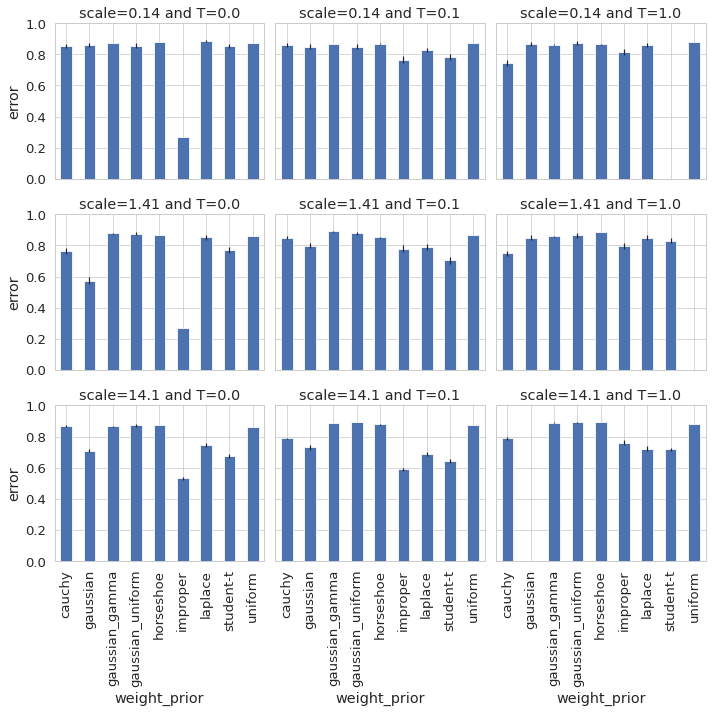

In [12]:
fig = plot_grid(runs_selected, y="error_mean", yerr="acc_stderr", ylabel="error", ylim=(0, 1.))

In [13]:
fig.savefig(f"../figures/{exp_name}_acc.pdf")

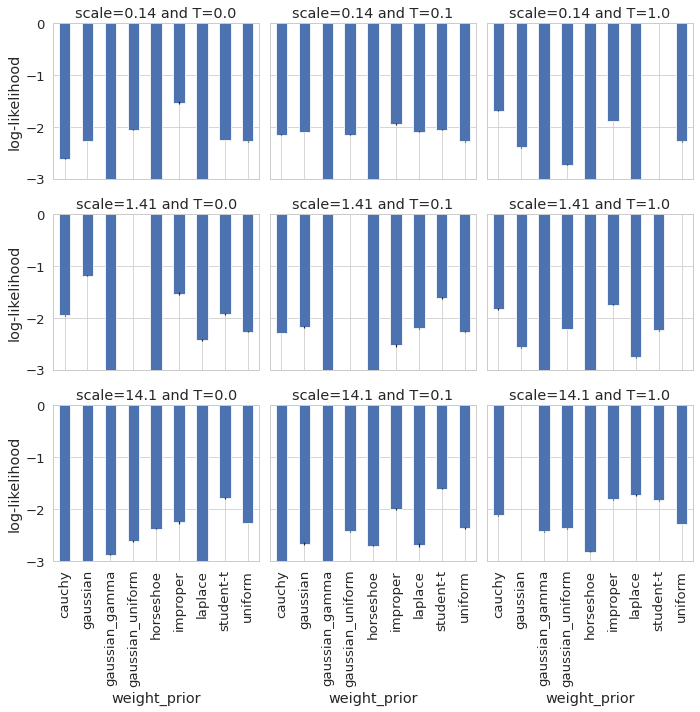

In [16]:
fig = plot_grid(runs_selected, y="lp_mean", yerr="lp_stderr", ylabel="log-likelihood", ylim=(-3., 0))

In [17]:
fig.savefig(f"../figures/{exp_name}_ll.pdf")

In [56]:
runs_selected = runs_all.query("eval_data == eval_data")

In [68]:
for col in runs_selected.columns:
    runs_selected[col] = runs_selected[col].astype(float, errors="ignore")

runs_selected = runs_selected.groupby(by=["weight_prior", "weight_scale", "temperature"]).mean()

runs_selected.reset_index(inplace=True)

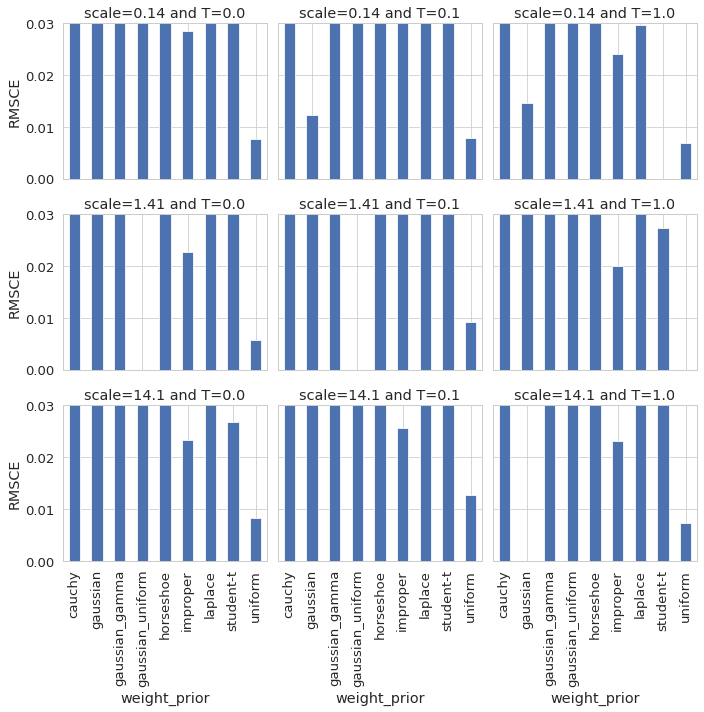

In [72]:
fig = plot_grid(runs_selected, y="rmsce", ylabel="RMSCE", ylim=(0, 0.03))

In [73]:
fig.savefig(f"../figures/{exp_name}_rmsce.pdf")

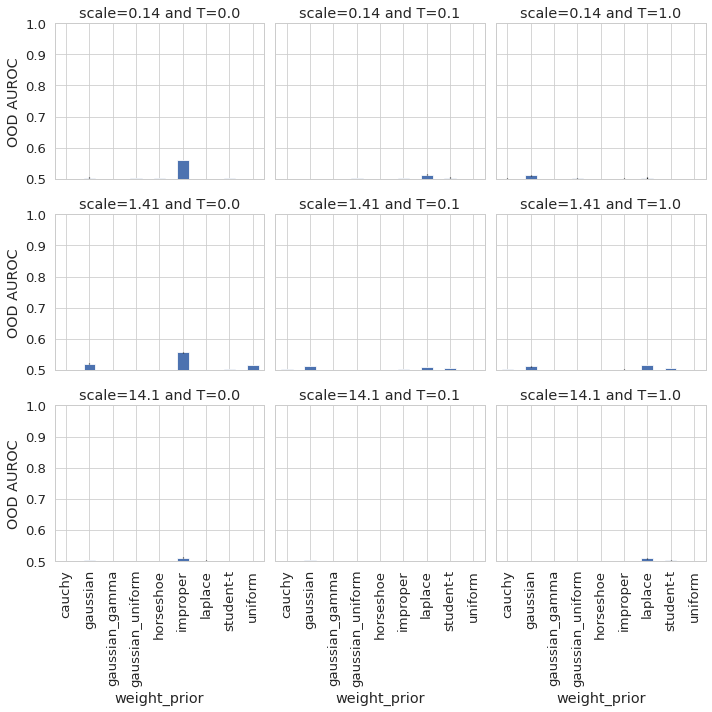

In [74]:
fig = plot_grid(runs_selected, y="auroc_mean", yerr="auroc_stderr", ylabel="OOD AUROC", ylim=(0.5, 1.))

In [75]:
fig.savefig(f"../figures/{exp_name}_ood.pdf")